# Homework 3 

In [1]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io as io
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

forest


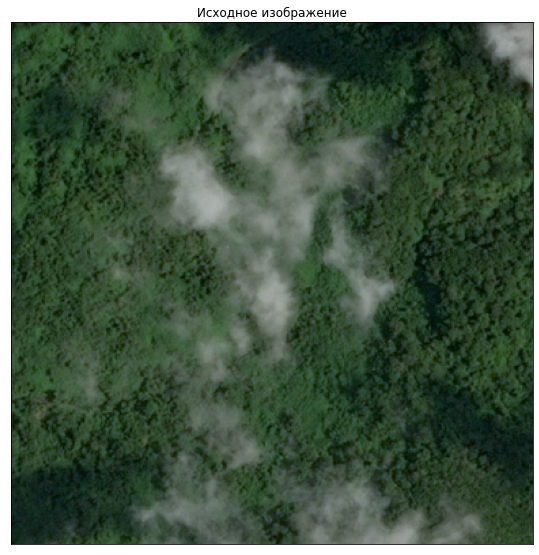

In [3]:
image = cv2.imread('desert_forest/test_image_00.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
imageHSV = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2HSV)

hist = cv2.calcHist(imageHSV, [0], None, [256], [0, 256])

fig, ax1 = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)

ax1.set_title('Исходное изображение')
ax1.imshow(image), ax1.set_xticks([]), ax1.set_yticks([])
Max = np.argmax(hist)
if(Max <= 45):
    print('desert')
else:
    print('forest')

# Задача №2 - Кусочки пазла.

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* В качестве первого изображения, начиная с которого нужно собрать пазл, всегда принимается верхняя левая часть изображения;
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Примеры изображений:
<img src="https://i.ibb.co/H78VtDb/image.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="https://i.ibb.co/Yh1dvJ8/image_part_002.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/N9sCpjH/image_part_001.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/jf1jGgD/image_part_004.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/kBGYb8s/image_part_003.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

<ipython-input-4-c0c18efac3bb>:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


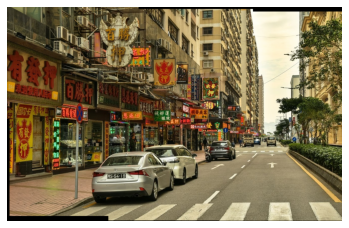

In [4]:
def search_start(image, images):
    for part in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        grayP = cv2.cvtColor(part, cv2.COLOR_RGB2GRAY)
        
        h, w, _ = part.shape
        
        cross = cv2.matchTemplate(gray, grayP, cv2.TM_CCOEFF_NORMED)
        loc = np.where(cross >= 0.99)
        
        if(loc[0] == 0):
            return part

def creat_image(images, newImage, hT, wT):
    part = 0
    threshold = 0.99
    while (len(images) != 0):
        if(part >= len(images)):
            part = 0
            threshold -= 0.01
        gray = cv2.cvtColor(newImage, cv2.COLOR_RGB2GRAY)
        h, w, _ = images[part].shape
        template = images[part][:min(hT, h), 0]
        template = template.reshape(-1, 1, 3)
        grayT = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        cross = cv2.matchTemplate(gray, grayT, cv2.TM_CCOEFF_NORMED)
        
        loc = np.where(cross >= threshold)
        
        if(len(loc[0]) > 0):
            newImage[loc[0][0] : loc[0][0] + h, loc[1][0] : loc[1][0] + w] = images[part]
            wT = loc[1][0] + w
            hT = loc[0][0] + h
            images = np.delete(images, part, 0)
            part = 0
        
        else:
            template = images[part][0, :min(wT, w)]
            template = template.reshape(1, -1, 3)
            grayT = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
            cross = cv2.matchTemplate(gray, grayT, cv2.TM_CCOEFF_NORMED)

            loc = np.where(cross >= threshold)
            
            if(len(loc[0]) > 0):
                newImage[loc[0][0] : loc[0][0] + h, loc[1][0] : loc[1][0] + w] = images[part]
                wT = loc[1][0] + w
                hT = loc[0][0] + h
                images = np.delete(images, part, 0)
                part = 0
            else:
                part +=1     
    return newImage
        
        
    
images = []
image = cv2.imread('puzzle/china_street_cut/image.jpg')
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
newImage = np.zeros_like(image)

for i in range(2,9):
    part = cv2.imread('puzzle/china_street_cut/image_part_0{}.jpg'.format(i))
    part = cv2.cvtColor(part.copy(), cv2.COLOR_BGR2RGB)
    images.append(part)

images = np.array(images)
start = search_start(image, images)
h, w, _ = start.shape
newImage[:h, :w] = start
newImage = creat_image(images, newImage, h, w)
plt.imshow(newImage)
plt.axis('off')
plt.show()

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [5]:
squareSize, squareCount = 300, 25
image = cv2.imread('cells/train0_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
_, thresh = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY_INV)
thresh = cv2.cvtColor(thresh, cv2.COLOR_RGB2GRAY)
thresh = thresh.astype(np.float32)
thresh /= 255.

In [6]:
segments = [thresh]
segmentsCord = [[0, 0]]
segmentsCount = 0
while(segmentsCount != len(segments)):
    segmentsCount = len(segments)
    segCord = []
    seg = []
    for j in range(len(segments)):
        segment = segments[j]
        start = 0
        for i in range(len(segment)):
            if(np.mean(segment[i]) == 0):
                if(start != i):
                    seg.append(segment[start : i + 1])
                    segCord.append([segmentsCord[j][0], segmentsCord[j][1] + start])
                start = i + 1
        if(start != i + 1):     
            seg.append(segment[start : i + 1])
            segCord.append([segmentsCord[j][0], segmentsCord[j][1] + start])

    segments = []
    segmentsCord = []

    for j in range(len(seg)):
        segment = seg[j]
        start = 0
        for i in range(len(segment[0])):
            if(np.mean(segment[:, i]) == 0):
                if(start != i):
                    segments.append(segment[:, start : i + 1])
                    segmentsCord.append([segCord[j][0] + start, segCord[j][1]])
                start = i + 1
        if(start != i + 1):
            segments.append(segment[:, start : i + 1])
            segmentsCord.append([segCord[j][0] + start, segCord[j][1]])

In [7]:
def square_on_plot(image, squareSize, coord, rectangles):
    h, w = image.shape
    startH = (h % squareSize) // 2
    startW = (w % squareSize) 
    i = startH
    
    while(i < h - startH):
        first = 0
        mean = np.mean(image[i : i + squareSize, :], axis = 0)
        jM = np.argmax(mean) - squareSize / 2
        if(jM < 0):
            j = 3
        else:
            j = jM.astype(np.int64)
        while(j < w - startW):
            if(np.mean(image[i : i + squareSize, j]) > 0):
                rectangles.append({'mean' : np.mean(image[i : i + squareSize, j : j + squareSize]), 'cord' : [j + coord[0] ,i + coord[1]]})
                j += squareSize + 3
                first = 1
            else:
                j += 1
        if(jM < 0):
            j = 3
        else:
            j = jM.astype(np.int64) - 3
        while(j > startW):
            if(np.mean(image[i : i + squareSize, j]) > 0):
                rectangles.append({'mean' : np.mean(image[i : i + squareSize, j - squareSize : j]), 'cord' : [j - squareSize + coord[0] ,i + coord[1]]})
                j -= squareSize + 3
                first = 1
            else:
                j -= 1
        i += squareSize + 3 * first
    return rectangles
        

In [8]:
rectangles = []
for i in range(len(segments)):
    rectangles = square_on_plot(segments[i], squareSize - 3, segmentsCord[i], rectangles)
    
rectangles = sorted(rectangles, key = lambda rectangle : rectangle.get('mean'), reverse = True)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
def draw_rectangle(image, rectangles, squareSize):
    for rectangle in rectangles:
        cv2.rectangle(image, (rectangle.get('cord')[0], rectangle.get('cord')[1]), (rectangle.get('cord')[0] + squareSize, rectangle.get('cord')[1] + squareSize), (0, 0 ,0), 3)

In [10]:
newImage = image.copy()
draw_rectangle(newImage, rectangles[:squareCount], 300)

io.imsave("test1.jpeg", newImage)

In [11]:
def draw_card(image, rectangles, squareSize):
    count = (np.sqrt(len(rectangles))).astype(np.int64)
    card = np.zeros((count * squareSize, count * squareSize, 3), np.uint8)
    for i in range(len(rectangles)):
        startX, startY = rectangles[i].get('cord')[0], rectangles[i].get('cord')[1]
        endX, endY = startX + squareSize, startY + squareSize
        card[i // count * squareSize : i // count * squareSize + squareSize, i % count * squareSize : i % count * squareSize + squareSize, :] = image[startY : endY, startX : endX, :]
    
    return card

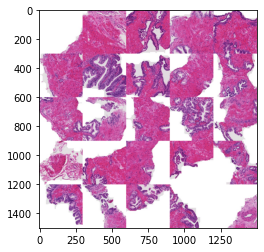

In [12]:
card = draw_card(image, rectangles[:squareCount], squareSize)
plt.imshow(card)
plt.show()